# Aplicando modelagem de assuntos ao DHBB
Neste capítulo vamos explorar ferramentas de modelagem de assuntos e explorar aplicações ao DHBB. Como sempre, começamos com alguns imports familiares.

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
import os, glob, pickle
import numpy as np
import spacy
from spacy import displacy
from sqlalchemy import create_engine
from dhbbmining import *
import ipywidgets as widgets
from tqdm import tqdm

Vamos também carregar o modelo de NLP para a língua portuguesa do Spacy:

In [48]:
# Descomente a linha abaixo para instalar
#!python3 -m spacy download pt_core_news_sm

In [5]:
nlp = spacy.load("pt_core_news_sm")

Agora faremos alguns imports novos, particularmente da biblioteca [Gensim](https://radimrehurek.com/gensim), que nos oferece as ferramentas que necessitamos para modelagem de assuntos.

In [6]:
from string import punctuation
from gensim.test.utils import datapath
from gensim import utils
from gensim.models import Word2Vec, word2vec

Para minimizar o uso de memória, vamos construir uma classe para representar o nosso corpus como um iterador, operando diretamente do banco de dados. Desta forma, ao fazer nossas análises, podemos carregar um documento por vez para alimentar os modelos, sem a necessidade de manter todo o corpus na memória, economizando memória RAM.

In [9]:
eng = create_engine("sqlite:///minha_tabela.sqlite")

class DHBBCorpus:
    """
    Iterador de documentos quebrados em frases
    """
    def __init__(self, ndocs=10000):
        self.ndocs = min(7687,ndocs)
        self.counter = 1
    def __iter__(self):
        with eng.connect() as con:
            res = con.execute(f'select corpo from resultados limit {self.ndocs};')
            for doc in res:
                d = self.pre_process(doc[0])
                if self.counter%10 == 0:
                    print (f"Verbete {self.counter} de {6*self.ndocs}\r", end='')
                for s in d:
                    yield s
                self.counter += 1
    def pre_process(self, doc):
        n = nlp(doc, disable=['tagger', 'ner','entity-linker', 'textcat','entity-ruler','merge-noun-chunks','merge-entities','merge-subtokens'])
        results = []
        for sentence in n.sents:
            s = sentence.text.split()
            if not s:
                continue
            results.append([token.strip().strip(punctuation) for token in s if token.strip().strip(punctuation)])
        return results
        

Abaixo um pequeno exemplo de como a classe `DHBBCorpus` funciona:

In [10]:
DC = DHBBCorpus(5)
for f in DC:
    pass
    print(f)
    break
    

['«PARTIDO', 'POPULAR', 'DO', 'DISTRITO', 'FEDERAL»', 'Partido', 'político', 'do', 'Rio', 'de', 'Janeiro', 'então', 'Distrito', 'Federal', 'fundado', 'em', '1933']


## Word2vec 
Vamos começar pelo treinamento de um modelo word2vec. Este modelo itera 6 vezes sobre o corpus logo, devemos ver o contador atingir 46122. Estas repetições são necessárias para permitir a melhor estimação da representação vetorial das palavras em um espaço semântico.

In [12]:
if os.path.exists('dhbb.w2v'):
    model = Word2Vec.load('dhbb.w2v')
else:
    DC = DHBBCorpus()
    model = Word2Vec(sentences=DC, workers=32)
    model.save('dhbb.w2v')

### Explorando o modelo
Como dito anteriormente o modelo do Word2Vec representa cada palavra do vocabulário do corpus como um vetor. Vejamos as dez primeiras palavras:

In [13]:
for i, word in enumerate(model.wv.index_to_key):
    if i == 10:
        break
    print(word)

de
a
do
e
da
o
em
que
no
na


Enquanto vetores podemos realizar operações aritméticas entre eles. Por exemplo se subtrairmos os vetores de *Deputado* e  *deputado* encontraremos que a magnitude do vetor resultante é bem pequena, pois estão muito próximos no espaço vetorial:

In [20]:
vec = model.wv['Deputado'] - model.wv['deputado']
print(f"Todos os vetores tem dimensão {len(vec)}")
np.linalg.norm(vec)


todos os vetores tem dimensão 100


24.32071

O tamanho total do vocabulário (palavras distintas) é de:

In [21]:
print(f"{len(model.wv.index_to_key)} palavras")

38762 palavras


Usando a mesma lógica de operações sobre os vetores, podemos usar palavras como representantes de seu significado, efetivamente estabelecendo um cálculo conceitual. Por exemplo: Abaixo vamos buscar as palavras mais similares semanticamente com o conceito de **direita** e ao mesmos antagônicas ao conceito de "Comunista". Como o corpus do DHBB tem um claro viés político, vemos o termo *direita* tomar a conotação política usual.

In [23]:
model.wv.most_similar(positive=['direita'],negative=['Comunista'], topn=20)

[('progressistas', 0.5529391169548035),
 ('segmentos', 0.5388556718826294),
 ('conservadores', 0.5193644165992737),
 ('antigetulistas', 0.515348494052887),
 ('setores', 0.5146178603172302),
 ('nacionalistas', 0.5058426856994629),
 ('esquerda', 0.5054914951324463),
 ('oposição', 0.4820389747619629),
 ('extrema', 0.47334492206573486),
 ('oposicionistas', 0.4595625698566437),
 ('adeptos', 0.44704267382621765),
 ('udenistas', 0.44662249088287354),
 ('centro-esquerda', 0.44410112500190735),
 ('radicais', 0.43817466497421265),
 ('pessedistas', 0.4352889060974121),
 ('moderados', 0.4338815212249756),
 ('liberais', 0.43283340334892273),
 ('jovens', 0.43128761649131775),
 ('grupos', 0.42958810925483704),
 ('ambientalistas', 0.42890769243240356)]

O número total de tokens no corpus é de:

In [24]:
model.corpus_total_words

8713256

### Visualizando os vetores de palavras
Como os palavras estão inseridas um espaço vetorial de dimensão 100, fica difícil visualizar o seu posicionamento relativo mas podemos nos utilizar de métodos de redução de dimensionalidade com o [TSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), para visualizarmos um pequeno numero (200) delas.

In [36]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    i = 0
    for word in model.wv.index_to_key:
        vectors.append(model.wv[word])
        labels.append(word)
        i+=1
        if i>200:
            break

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go
    layout = go.Layout(
        autosize=False,
        width=800,
        height=600
    )

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels, opacity=0.8)
    data = [trace]
    fig = go.Figure(
    data= data,
    layout= layout)

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(fig, filename='word-embedding-plot')
    else:
        plot(fig, filename='word-embedding-plot.html')

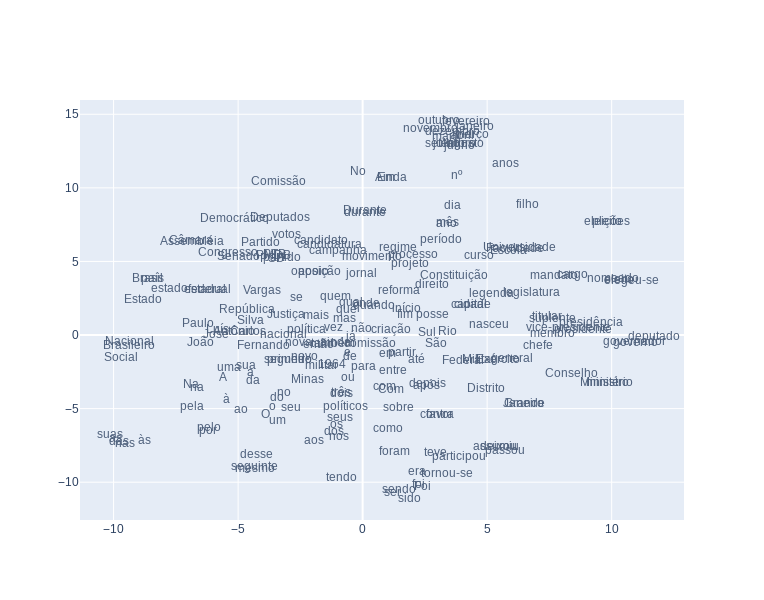

In [37]:
plot_with_plotly(x_vals, y_vals, labels)

Outros exemplos de combinação de conceitos.

In [40]:
model.wv.most_similar(positive=['deputado', 'mulher'], negative=['homem'])

[('deputada', 0.707239031791687),
 ('senadora', 0.6504750847816467),
 ('governadora', 0.5311956405639648),
 ('vaga', 0.5001533031463623),
 ('senador', 0.49622222781181335),
 ('bancada', 0.49382296204566956),
 ('prefeita', 0.4898069202899933),
 ('esposa', 0.4874173700809479),
 ('vereadora', 0.477497398853302),
 ('ex-deputado', 0.4704161286354065)]

In [41]:
model.wv.most_similar(positive=['Sergipe', 'Salvador'], negative=['Bahia'])

[('Aracaju', 0.7568933963775635),
 ('Fortaleza', 0.7413235306739807),
 ('Maceió', 0.7330026030540466),
 ('Manaus', 0.729759693145752),
 ('Curitiba', 0.722693920135498),
 ('Teresina', 0.7146587371826172),
 ('Cuiabá', 0.7008069753646851),
 ('Dourados', 0.6986944675445557),
 ('Belém', 0.6970897912979126),
 ('Goiânia', 0.6968613862991333)]

In [42]:
model.wv.most_similar(positive=['congressista', 'política'], negative=['homem'])

[('independente”', 0.5179454684257507),
 ('Iniciando-se', 0.47886374592781067),
 ('turística', 0.477364718914032),
 ('duradouras', 0.4718947410583496),
 ('“política', 0.4573584198951721),
 ('induzida', 0.45302215218544006),
 ('marxista”', 0.4503825306892395),
 ('conflituosas', 0.45008936524391174),
 ('pragmática', 0.4451919496059418),
 ('stalinista', 0.4449922740459442)]

In [43]:
model.wv['congressista'] + model.wv['política']-model.wv['homem']

array([-1.1804812 ,  0.17904007,  2.7701726 ,  2.2788234 , -2.3939579 ,
       -1.6261489 ,  3.037264  , -1.5370936 ,  0.1686287 ,  1.7679174 ,
       -0.6206008 , -1.4379971 ,  0.9625195 ,  5.3786445 , -1.5540149 ,
       -0.00777411, -1.401691  , -4.2874527 , -0.82898766,  1.8527349 ,
        1.1073897 ,  0.4124229 , -1.7202759 , -1.9285159 ,  0.22249055,
       -0.1637733 ,  0.3505941 , -1.6477919 ,  3.5996528 , -1.884695  ,
        0.70941716,  2.4855223 ,  0.19784053,  1.0554858 , -2.0812526 ,
        0.25975254,  1.0439771 ,  0.40970242,  0.78404856, -2.2612848 ,
        1.7169695 ,  0.73526394,  1.4105549 ,  4.066178  , -0.40555423,
        1.8521545 ,  3.7054353 ,  1.3822607 , -4.056506  ,  1.9932911 ,
        0.89136565, -2.6281335 ,  3.6849546 ,  3.6759586 , -0.3893448 ,
       -0.93963474,  3.059989  ,  0.07065499, -0.69516784, -1.2888556 ,
        0.92977023, -1.6649121 ,  2.6862006 , -2.4784298 ,  1.8600826 ,
        0.779212  ,  2.1920981 , -1.9809456 , -2.688896  ,  0.60

## Word Movers Distance
Este método permite que calculemos a distância entre dois documentos mesmo que estes não contenham palavras em comum. Este método foi proposto no artigo ["From Word Embeddings To Document Distances"](http://jmlr.org/proceedings/papers/v37/kusnerb15.pdf).

In [ ]:
!pip install pyemd

In [45]:
DC = list(DHBBCorpus(5))
model.wv.wmdistance(document1=DC[1],document2=DC[2])

1.1409154016167715

In [46]:
print(DC[1])
print(DC[2])

['Era', 'presidido', 'por', 'João', 'Câncio', 'da', 'Silva']
['Nas', 'eleições', 'para', 'a', 'Assembléia', 'Nacional', 'Constituinte', 'de', '1933', 'apresentou', 'uma', 'chapa', 'composta', 'por', 'Américo', 'Basílio', 'Silvado', 'Henrique', 'de', 'Toledo', 'Dodsworth', 'Amélio', 'Dias', 'de', 'Morais', 'Adolfo', 'Bergamini', 'Jones', 'Gonçalves', 'Rocha', 'José', 'Matoso', 'de', 'Sampaio', 'Correia', 'Antenor', 'Esposel', 'Coutinho', 'Inácio', 'Bittencourt', 'Berta', 'Lutz', 'e', 'Georgina', 'de', 'Araújo', 'Lima']


Vamos comparar o documento 1 acima (*Era presidido por João Câncio da Silva*) com outro sem nenhuma palavra em comum, e veremos que é possível calcular uma distância.

In [47]:
model.wv.wmdistance(document1=DC[1],document2='frequentou a escola religiosa em Niteroi e formou-se em 1935 pela UFF'.split())

1.2811055265149547